In [118]:
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

In [119]:
import tensorflow
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [120]:
look_back = 7
epochs = 500
batch_size = 32
#

In [121]:
np.random.seed(7)

# read all prices using panda
prices_dataset =  pd.read_csv('prices-split-adjusted.csv', header=0)

# filter out only data of Apple
apple = prices_dataset[prices_dataset['symbol']=='BOXL']

# save Apple's stock values as type of floating point number
apple_stock_prices = apple.close.values.astype('float32')
#

In [122]:
df =  pd.read_csv('boxl.csv', header=0)

In [123]:
df.head()

,Time,Open,High,Low,Last,Change,Volume
0,07/22/20 09:43,19.060,19.0900,19.0400,19.0700,0.0264,5214.0
1,07/22/20 09:42,19.025,19.0436,19.0200,19.0436,0.0636,1557.0
2,07/22/20 09:41,19.030,19.0300,18.9535,18.9800,-0.0600,5396.0
3,07/22/20 09:40,19.050,19.0650,19.0350,19.0400,0.0000,9681.0
4,07/22/20 09:39,19.040,19.0500,19.0200,19.0400,0.0200,1900.0


In [124]:
df.shape

(418, 7)

In [125]:
np.random.seed(7)

# read all prices using panda
prices_dataset =  pd.read_csv('boxl.csv', header=0)

# filter out only data of Apple
#apple = prices_dataset[prices_dataset['symbol']=='BOXL']

# save Apple's stock values as type of floating point number
apple_stock_prices = prices_dataset.Last.values.astype('float32')
#

In [126]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [127]:
TRAIN_SPLIT = 300

In [128]:
tensorflow.random.set_seed(13)

In [129]:
uni_data = df['Last']
uni_data.index = df['Time']
uni_data.head()

Time
07/22/20 09:43    19.0700
07/22/20 09:42    19.0436
07/22/20 09:41    18.9800
07/22/20 09:40    19.0400
07/22/20 09:39    19.0400
Name: Last, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023492BD5FD0>],
      dtype=object)

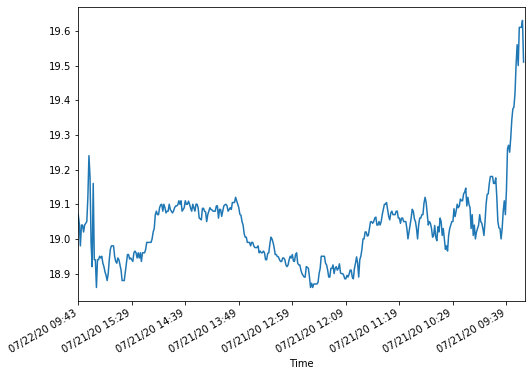

In [130]:
uni_data.plot(subplots=True)

In [131]:
uni_data = uni_data.values

In [132]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [133]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [134]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [135]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target price to predict')
print (y_train_uni[0])

Single window of past history
[[ 0.92658943]
 [ 0.58649988]
 [-0.23280675]
 [ 0.54012403]
 [ 0.54012403]
 [ 0.28248044]
 [ 0.54012403]
 [ 0.60453493]
 [ 0.66894583]
 [ 1.57069842]
 [ 3.11655999]
 [ 2.34362921]
 [-0.10269674]
 [-1.00573754]
 [ 2.08598561]
 [-0.74809395]
 [-0.74809395]
 [-1.77866833]
 [-0.74809395]
 [-0.74809395]]

 Target price to predict
-0.6192721473152014


In [136]:
def create_time_steps(length):
  return list(range(-length, 0))

In [137]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\FAYYAZ\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

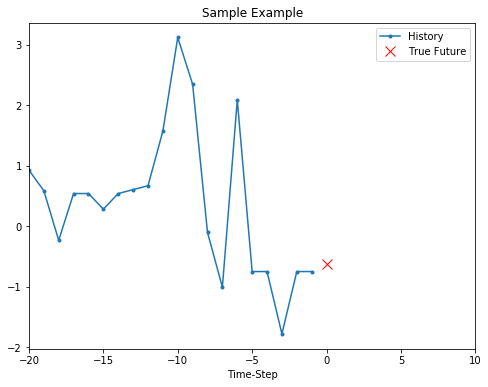

In [138]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [139]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\FAYYAZ\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

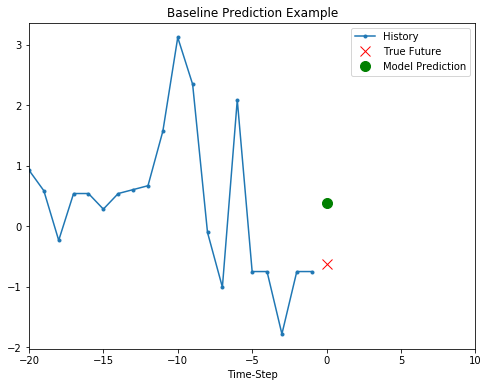

In [108]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Recurrent NN (LSTM)

In [140]:
BATCH_SIZE = 30
BUFFER_SIZE = 10000

train_univariate = tensorflow.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tensorflow.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [141]:
train_univariate

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

In [142]:
train_univariate

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

In [143]:
val_univariate

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

In [144]:
simple_lstm_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tensorflow.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [148]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(30, 1)


In [147]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 7s 35ms/step - loss: 0.4453 - val_loss: nan
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2244 - val_loss: nan
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2027 - val_loss: nan
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1857 - val_loss: nan
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1718 - val_loss: nan
Epoch 6/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1587 - val_loss: nan
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1490 - val_loss: nan
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1430 - val_loss: nan
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1405 - val_loss: nan
Epoch 10/10
200/200 [==============================] - 3s 15ms/step - loss:

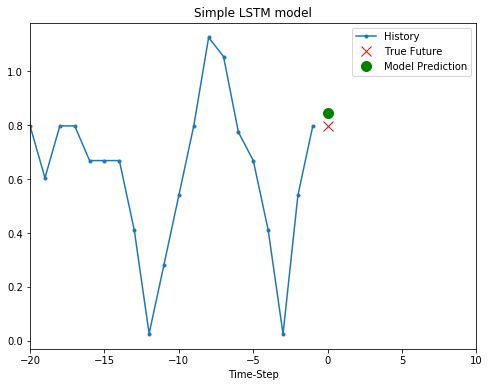

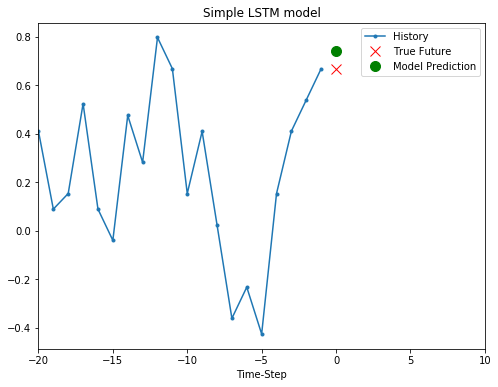

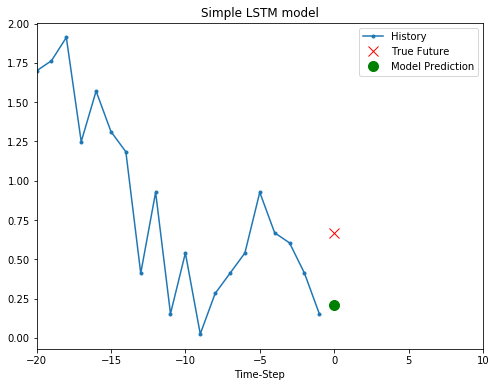

In [117]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [17]:
#apple_stock_prices

In [11]:
apple_stock_prices = apple_stock_prices.reshape(len(apple_stock_prices), 1)



In [12]:
apple_stock_prices

array([[19.07  ],
       [19.0436],
       [18.98  ],
       [19.04  ],
       [19.04  ],
       [19.02  ],
       [19.04  ],
       [19.045 ],
       [19.05  ],
       [19.12  ],
       [19.24  ],
       [19.18  ],
       [18.9901],
       [18.92  ],
       [19.16  ],
       [18.94  ],
       [18.94  ],
       [18.86  ],
       [18.94  ],
       [18.94  ],
       [18.95  ],
       [18.945 ],
       [18.95  ],
       [18.93  ],
       [18.92  ],
       [18.905 ],
       [18.895 ],
       [18.88  ],
       [18.9   ],
       [18.94  ],
       [18.97  ],
       [18.98  ],
       [18.98  ],
       [18.98  ],
       [18.95  ],
       [18.935 ],
       [18.93  ],
       [18.945 ],
       [18.94  ],
       [18.925 ],
       [18.91  ],
       [18.88  ],
       [18.88  ],
       [18.88  ],
       [18.905 ],
       [18.93  ],
       [18.955 ],
       [18.955 ],
       [18.942 ],
       [18.945 ],
       [18.94  ],
       [18.935 ],
       [18.96  ],
       [18.965 ],
       [18.96  ],
       [18

In [13]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
apple_stock_prices = scaler.fit_transform(apple_stock_prices)

In [14]:
apple_stock_prices

array([[0.27272606],
       [0.23844147],
       [0.15584183],
       [0.23376656],
       [0.23376656],
       [0.20779228],
       [0.23376656],
       [0.24025917],
       [0.24675179],
       [0.33766174],
       [0.49350548],
       [0.41558456],
       [0.16896057],
       [0.07792091],
       [0.3896103 ],
       [0.10389519],
       [0.10389519],
       [0.        ],
       [0.10389519],
       [0.10389519],
       [0.11688232],
       [0.1103878 ],
       [0.11688232],
       [0.09090805],
       [0.07792091],
       [0.05844116],
       [0.04545403],
       [0.02597046],
       [0.05194664],
       [0.10389519],
       [0.14285469],
       [0.15584183],
       [0.15584183],
       [0.15584183],
       [0.11688232],
       [0.09740067],
       [0.09090805],
       [0.1103878 ],
       [0.10389519],
       [0.08441353],
       [0.06493378],
       [0.02597046],
       [0.02597046],
       [0.02597046],
       [0.05844116],
       [0.09090805],
       [0.12337494],
       [0.123

In [15]:
apple_stock_prices.shape

(418, 1)

In [16]:
train_size = int(len(apple_stock_prices) * 0.67)
test_size = len(apple_stock_prices) - train_size
train, test = apple_stock_prices[0:train_size,:], apple_stock_prices[train_size:len(apple_stock_prices),:]

print('Split data into training set and test set... Number of training samples/ test samples:', len(train), len(test))

Split data into training set and test set... Number of training samples/ test samples: 280 138


In [17]:
apple_stock_prices[0:train_size,:]

array([[0.27272606],
       [0.23844147],
       [0.15584183],
       [0.23376656],
       [0.23376656],
       [0.20779228],
       [0.23376656],
       [0.24025917],
       [0.24675179],
       [0.33766174],
       [0.49350548],
       [0.41558456],
       [0.16896057],
       [0.07792091],
       [0.3896103 ],
       [0.10389519],
       [0.10389519],
       [0.        ],
       [0.10389519],
       [0.10389519],
       [0.11688232],
       [0.1103878 ],
       [0.11688232],
       [0.09090805],
       [0.07792091],
       [0.05844116],
       [0.04545403],
       [0.02597046],
       [0.05194664],
       [0.10389519],
       [0.14285469],
       [0.15584183],
       [0.15584183],
       [0.15584183],
       [0.11688232],
       [0.09740067],
       [0.09090805],
       [0.1103878 ],
       [0.10389519],
       [0.08441353],
       [0.06493378],
       [0.02597046],
       [0.02597046],
       [0.02597046],
       [0.05844116],
       [0.09090805],
       [0.12337494],
       [0.123

In [18]:
apple_stock_prices[train_size:len(apple_stock_prices),:]

array([[0.23376656],
       [0.24675179],
       [0.23376656],
       [0.24675179],
       [0.27272606],
       [0.2922058 ],
       [0.31168747],
       [0.31168747],
       [0.31818008],
       [0.2922058 ],
       [0.26623344],
       [0.2532463 ],
       [0.27922058],
       [0.2857132 ],
       [0.27272606],
       [0.27272606],
       [0.27272606],
       [0.2857132 ],
       [0.2857132 ],
       [0.25973892],
       [0.25973892],
       [0.24025917],
       [0.25973892],
       [0.25973892],
       [0.24675179],
       [0.24675179],
       [0.24675179],
       [0.22077942],
       [0.1819458 ],
       [0.20779228],
       [0.23376656],
       [0.25973892],
       [0.29285622],
       [0.2857132 ],
       [0.25740242],
       [0.24675179],
       [0.22077942],
       [0.1818161 ],
       [0.23376656],
       [0.25973892],
       [0.25973892],
       [0.27272606],
       [0.27272606],
       [0.31623268],
       [0.33766174],
       [0.31818008],
       [0.27506447],
       [0.233

In [27]:
# convert an array of values into a time series dataset 
# in form 
#                     X                     Y
# t-look_back+1, t-look_back+2, ..., t     t+1

def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
        
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY) 

# convert Apple's stock price data into time series dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input of the LSTM to be format [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [28]:
pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000

In [29]:
look_back

7

In [30]:
trainX.shape

(272, 7, 1)

In [31]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=epochs, batch_size=batch_size)

Train on 272 samples
Epoch 1/500
272/272 [==============================] - 2s 7ms/sample - loss: 0.0301
Epoch 2/500
272/272 [==============================] - 0s 168us/sample - loss: 0.0214
Epoch 3/500
272/272 [==============================] - 0s 180us/sample - loss: 0.0147
Epoch 4/500
272/272 [==============================] - 0s 180us/sample - loss: 0.0102
Epoch 5/500
272/272 [==============================] - 0s 187us/sample - loss: 0.0077
Epoch 6/500
272/272 [==============================] - 0s 184us/sample - loss: 0.0063
Epoch 7/500
272/272 [==============================] - 0s 188us/sample - loss: 0.0058
Epoch 8/500
272/272 [==============================] - 0s 180us/sample - loss: 0.0056
Epoch 9/500
272/272 [==============================] - 0s 169us/sample - loss: 0.0054
Epoch 10/500
272/272 [==============================] - 0s 184us/sample - loss: 0.0052
Epoch 11/500
272/272 [==============================] - 0s 187us/sample - loss: 0.0050
Epoch 12/500
272/272 [===========

272/272 [==============================] - 0s 214us/sample - loss: 0.0019
Epoch 95/500
272/272 [==============================] - 0s 192us/sample - loss: 0.0019
Epoch 96/500
272/272 [==============================] - 0s 189us/sample - loss: 0.0019
Epoch 97/500
272/272 [==============================] - 0s 196us/sample - loss: 0.0019
Epoch 98/500
272/272 [==============================] - 0s 180us/sample - loss: 0.0019
Epoch 99/500
272/272 [==============================] - 0s 191us/sample - loss: 0.0019
Epoch 100/500
272/272 [==============================] - 0s 195us/sample - loss: 0.0019
Epoch 101/500
272/272 [==============================] - 0s 198us/sample - loss: 0.0019
Epoch 102/500
272/272 [==============================] - 0s 202us/sample - loss: 0.0019
Epoch 103/500
272/272 [==============================] - 0s 176us/sample - loss: 0.0019
Epoch 104/500
272/272 [==============================] - 0s 210us/sample - loss: 0.0019
Epoch 105/500
272/272 [============================

272/272 [==============================] - 0s 191us/sample - loss: 0.0017
Epoch 188/500
272/272 [==============================] - 0s 202us/sample - loss: 0.0017
Epoch 189/500
272/272 [==============================] - 0s 184us/sample - loss: 0.0017
Epoch 190/500
272/272 [==============================] - 0s 176us/sample - loss: 0.0017
Epoch 191/500
272/272 [==============================] - 0s 191us/sample - loss: 0.0017
Epoch 192/500
272/272 [==============================] - 0s 187us/sample - loss: 0.0017
Epoch 193/500
272/272 [==============================] - 0s 180us/sample - loss: 0.0016
Epoch 194/500
272/272 [==============================] - 0s 180us/sample - loss: 0.0016
Epoch 195/500
272/272 [==============================] - 0s 180us/sample - loss: 0.0016
Epoch 196/500
272/272 [==============================] - 0s 191us/sample - loss: 0.0016
Epoch 197/500
272/272 [==============================] - 0s 184us/sample - loss: 0.0016
Epoch 198/500
272/272 [=======================

272/272 [==============================] - 0s 173us/sample - loss: 0.0014
Epoch 374/500
272/272 [==============================] - 0s 184us/sample - loss: 0.0014
Epoch 375/500
272/272 [==============================] - 0s 169us/sample - loss: 0.0014
Epoch 376/500
272/272 [==============================] - 0s 176us/sample - loss: 0.0014
Epoch 377/500
272/272 [==============================] - 0s 173us/sample - loss: 0.0014
Epoch 378/500
272/272 [==============================] - 0s 173us/sample - loss: 0.0014
Epoch 379/500
272/272 [==============================] - 0s 176us/sample - loss: 0.0014
Epoch 380/500
272/272 [==============================] - 0s 173us/sample - loss: 0.0014
Epoch 381/500
272/272 [==============================] - 0s 173us/sample - loss: 0.0014
Epoch 382/500
272/272 [==============================] - 0s 169us/sample - loss: 0.0014
Epoch 383/500
272/272 [==============================] - 0s 169us/sample - loss: 0.0014
Epoch 384/500
272/272 [=======================

In [32]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [33]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [34]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.05 RMSE


In [35]:
# shift predictions of training data for plotting
trainPredictPlot = np.empty_like(apple_stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift predictions of test data for plotting
testPredictPlot = np.empty_like(apple_stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(apple_stock_prices)-1, :] = testPredict

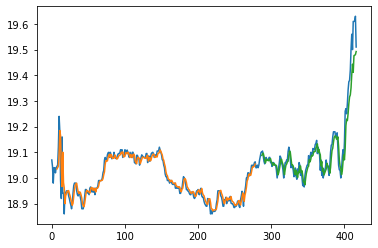

In [36]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(apple_stock_prices))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()